In [1]:
from transformers import pipeline
from PIL import Image
import requests

# load pipe
pipe = pipeline(task="depth-estimation", model="Intel/dpt-hybrid-midas")

# load image
url = '/mnt/20Jan20_SSD/Users/yeebe/Desktop/MQ/Thesis/Training_Data/data/depth_estimation/pharmacy.jpg'
image = Image.open(url)

# inference
depth = pipe(image)

2024-05-26 16:41:05.934506: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-26 16:41:08.078219: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/ben/miniforge3/envs/jupyter_labs/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/9.88k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/490M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/382 [00:00<?, ?B/s]

In [2]:
depth

{'predicted_depth': tensor([[[1532.3038, 1511.0452, 1506.8990,  ..., 1160.0428, 1156.2198,
            922.2342],
          [1491.7312, 1517.4025, 1512.9454,  ..., 1158.2374, 1151.0441,
           1160.5753],
          [1527.9846, 1522.6348, 1513.3480,  ..., 1156.3905, 1158.1937,
           1159.9358],
          ...,
          [1867.8557, 1865.5460, 1862.7686,  ..., 1789.7256, 1784.6873,
           1782.8398],
          [1874.9200, 1870.2676, 1871.1428,  ..., 1791.2924, 1793.6559,
           1782.3577],
          [1858.2316, 1870.7448, 1869.0691,  ..., 1798.4408, 1793.0962,
           1783.3169]]]),
 'depth': <PIL.Image.Image image mode=L size=3264x1836>}

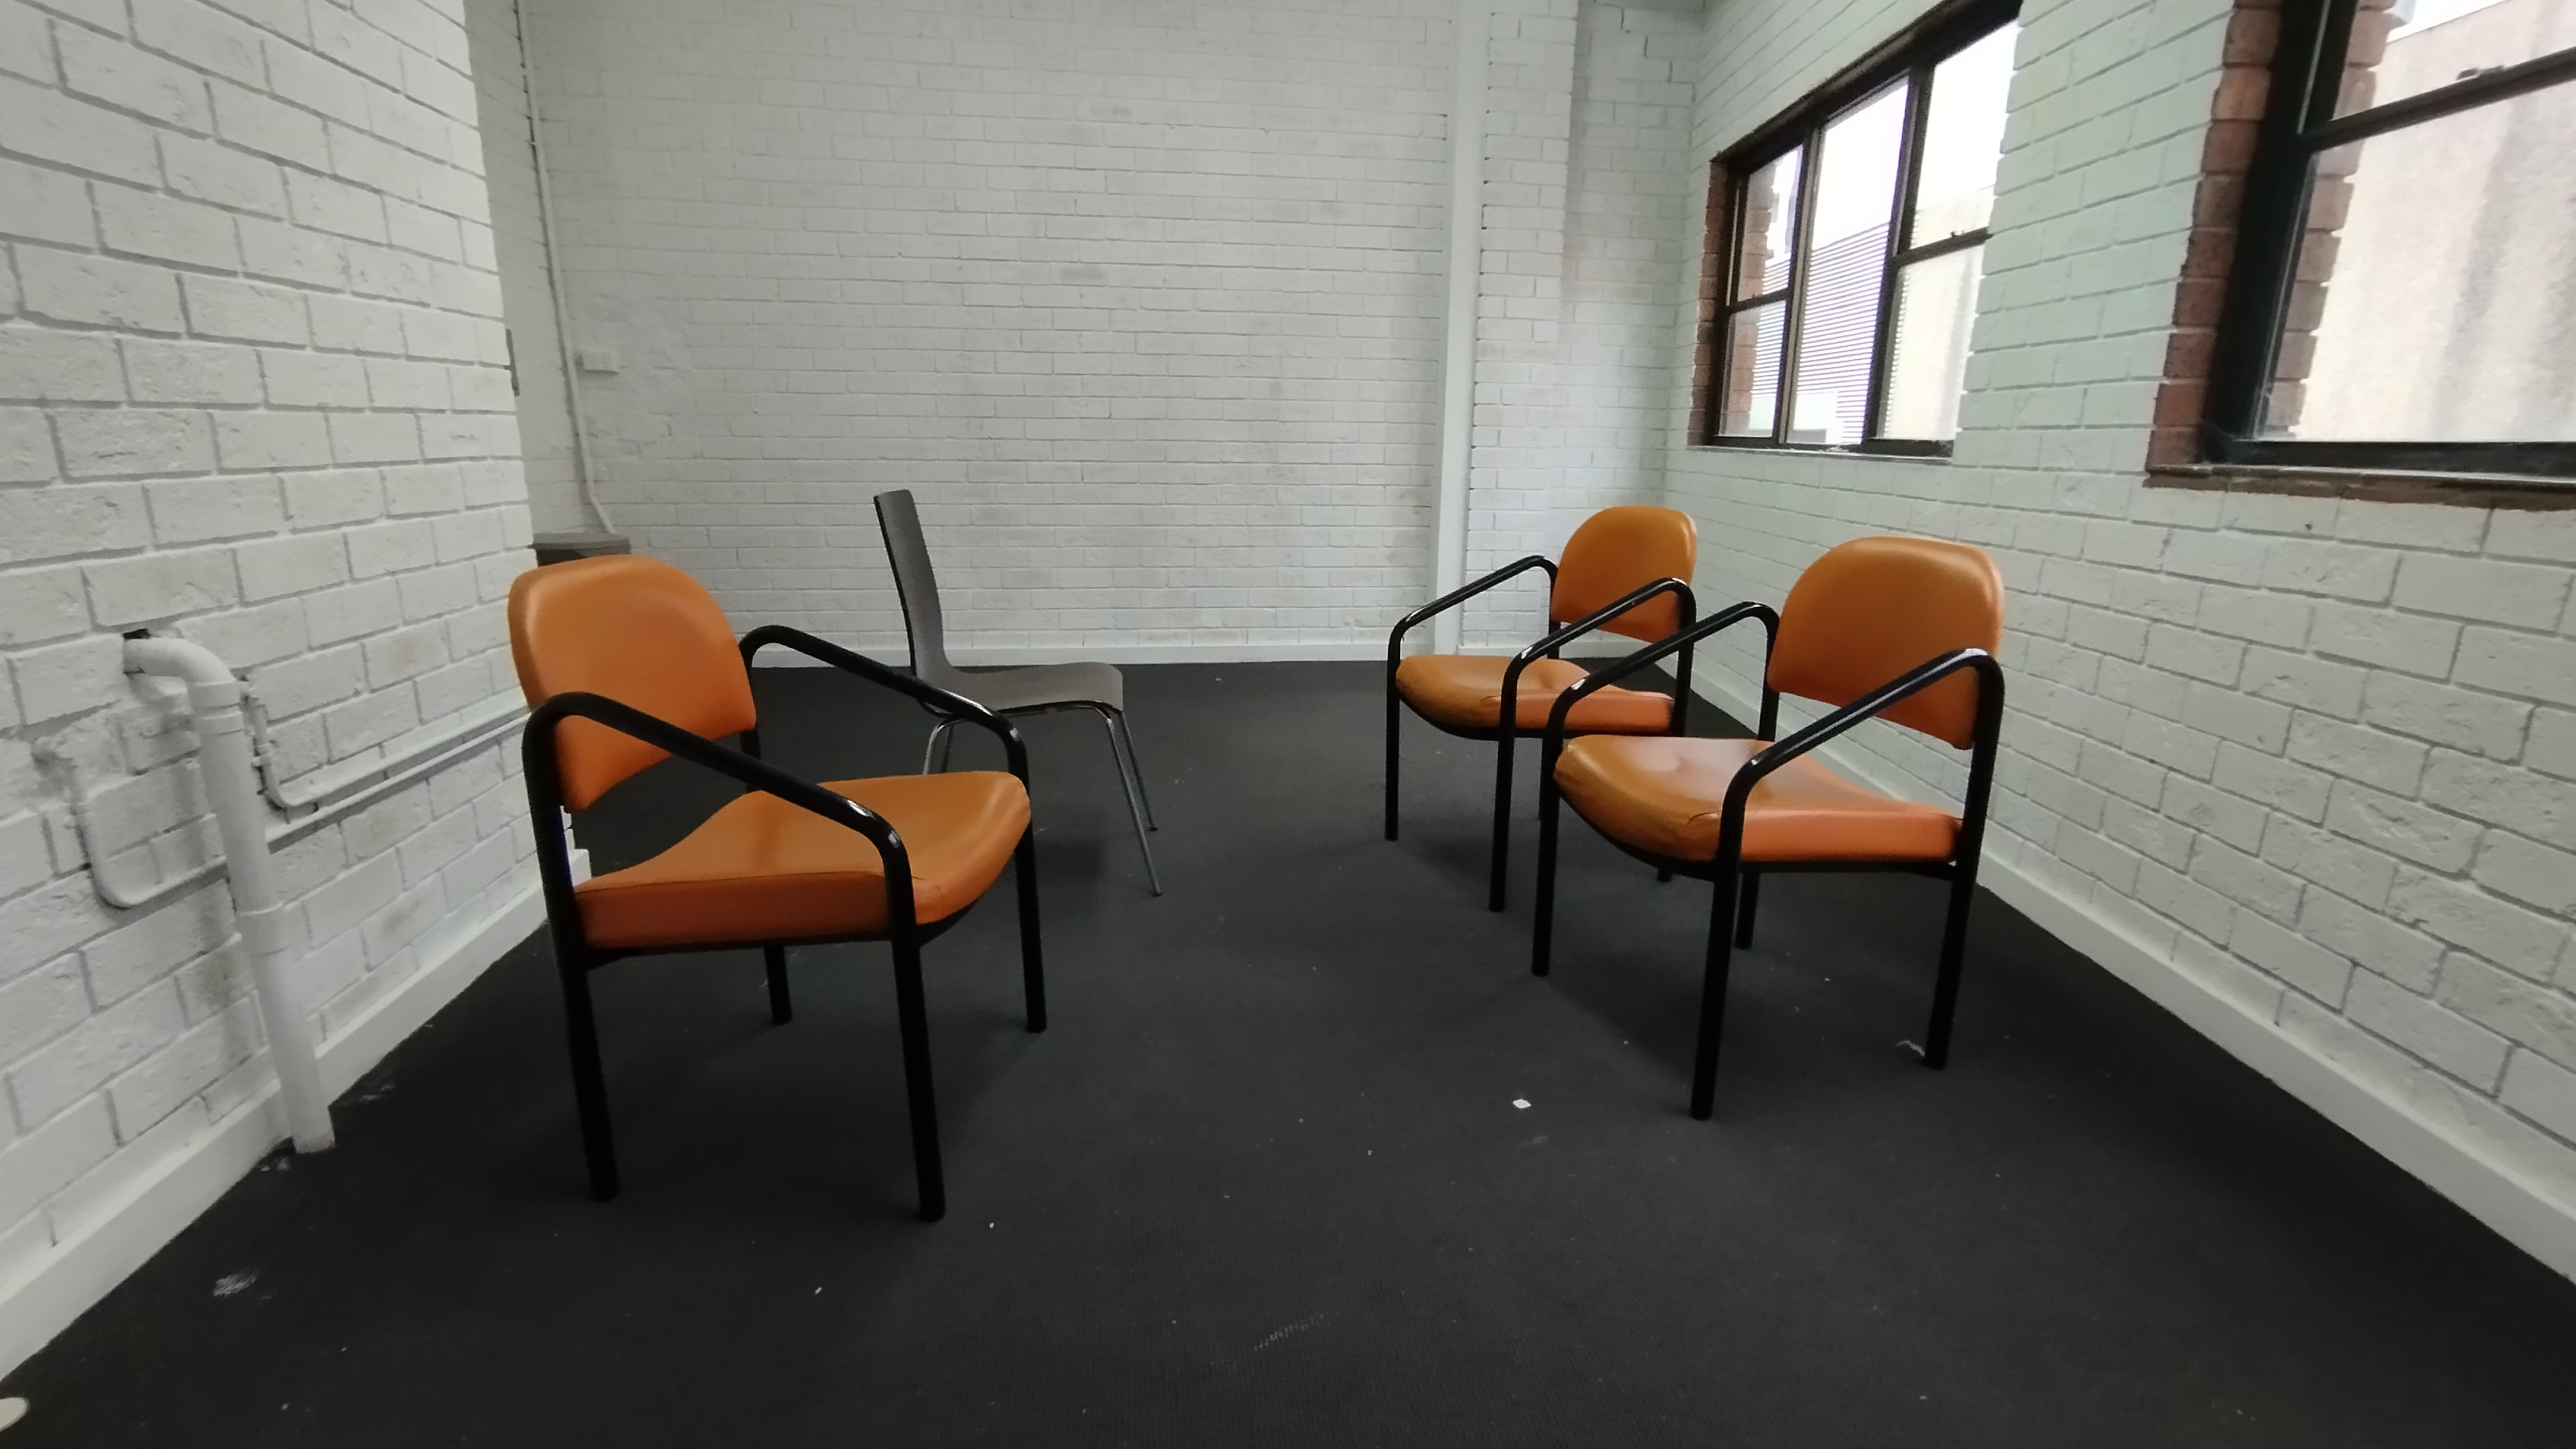

In [3]:
image

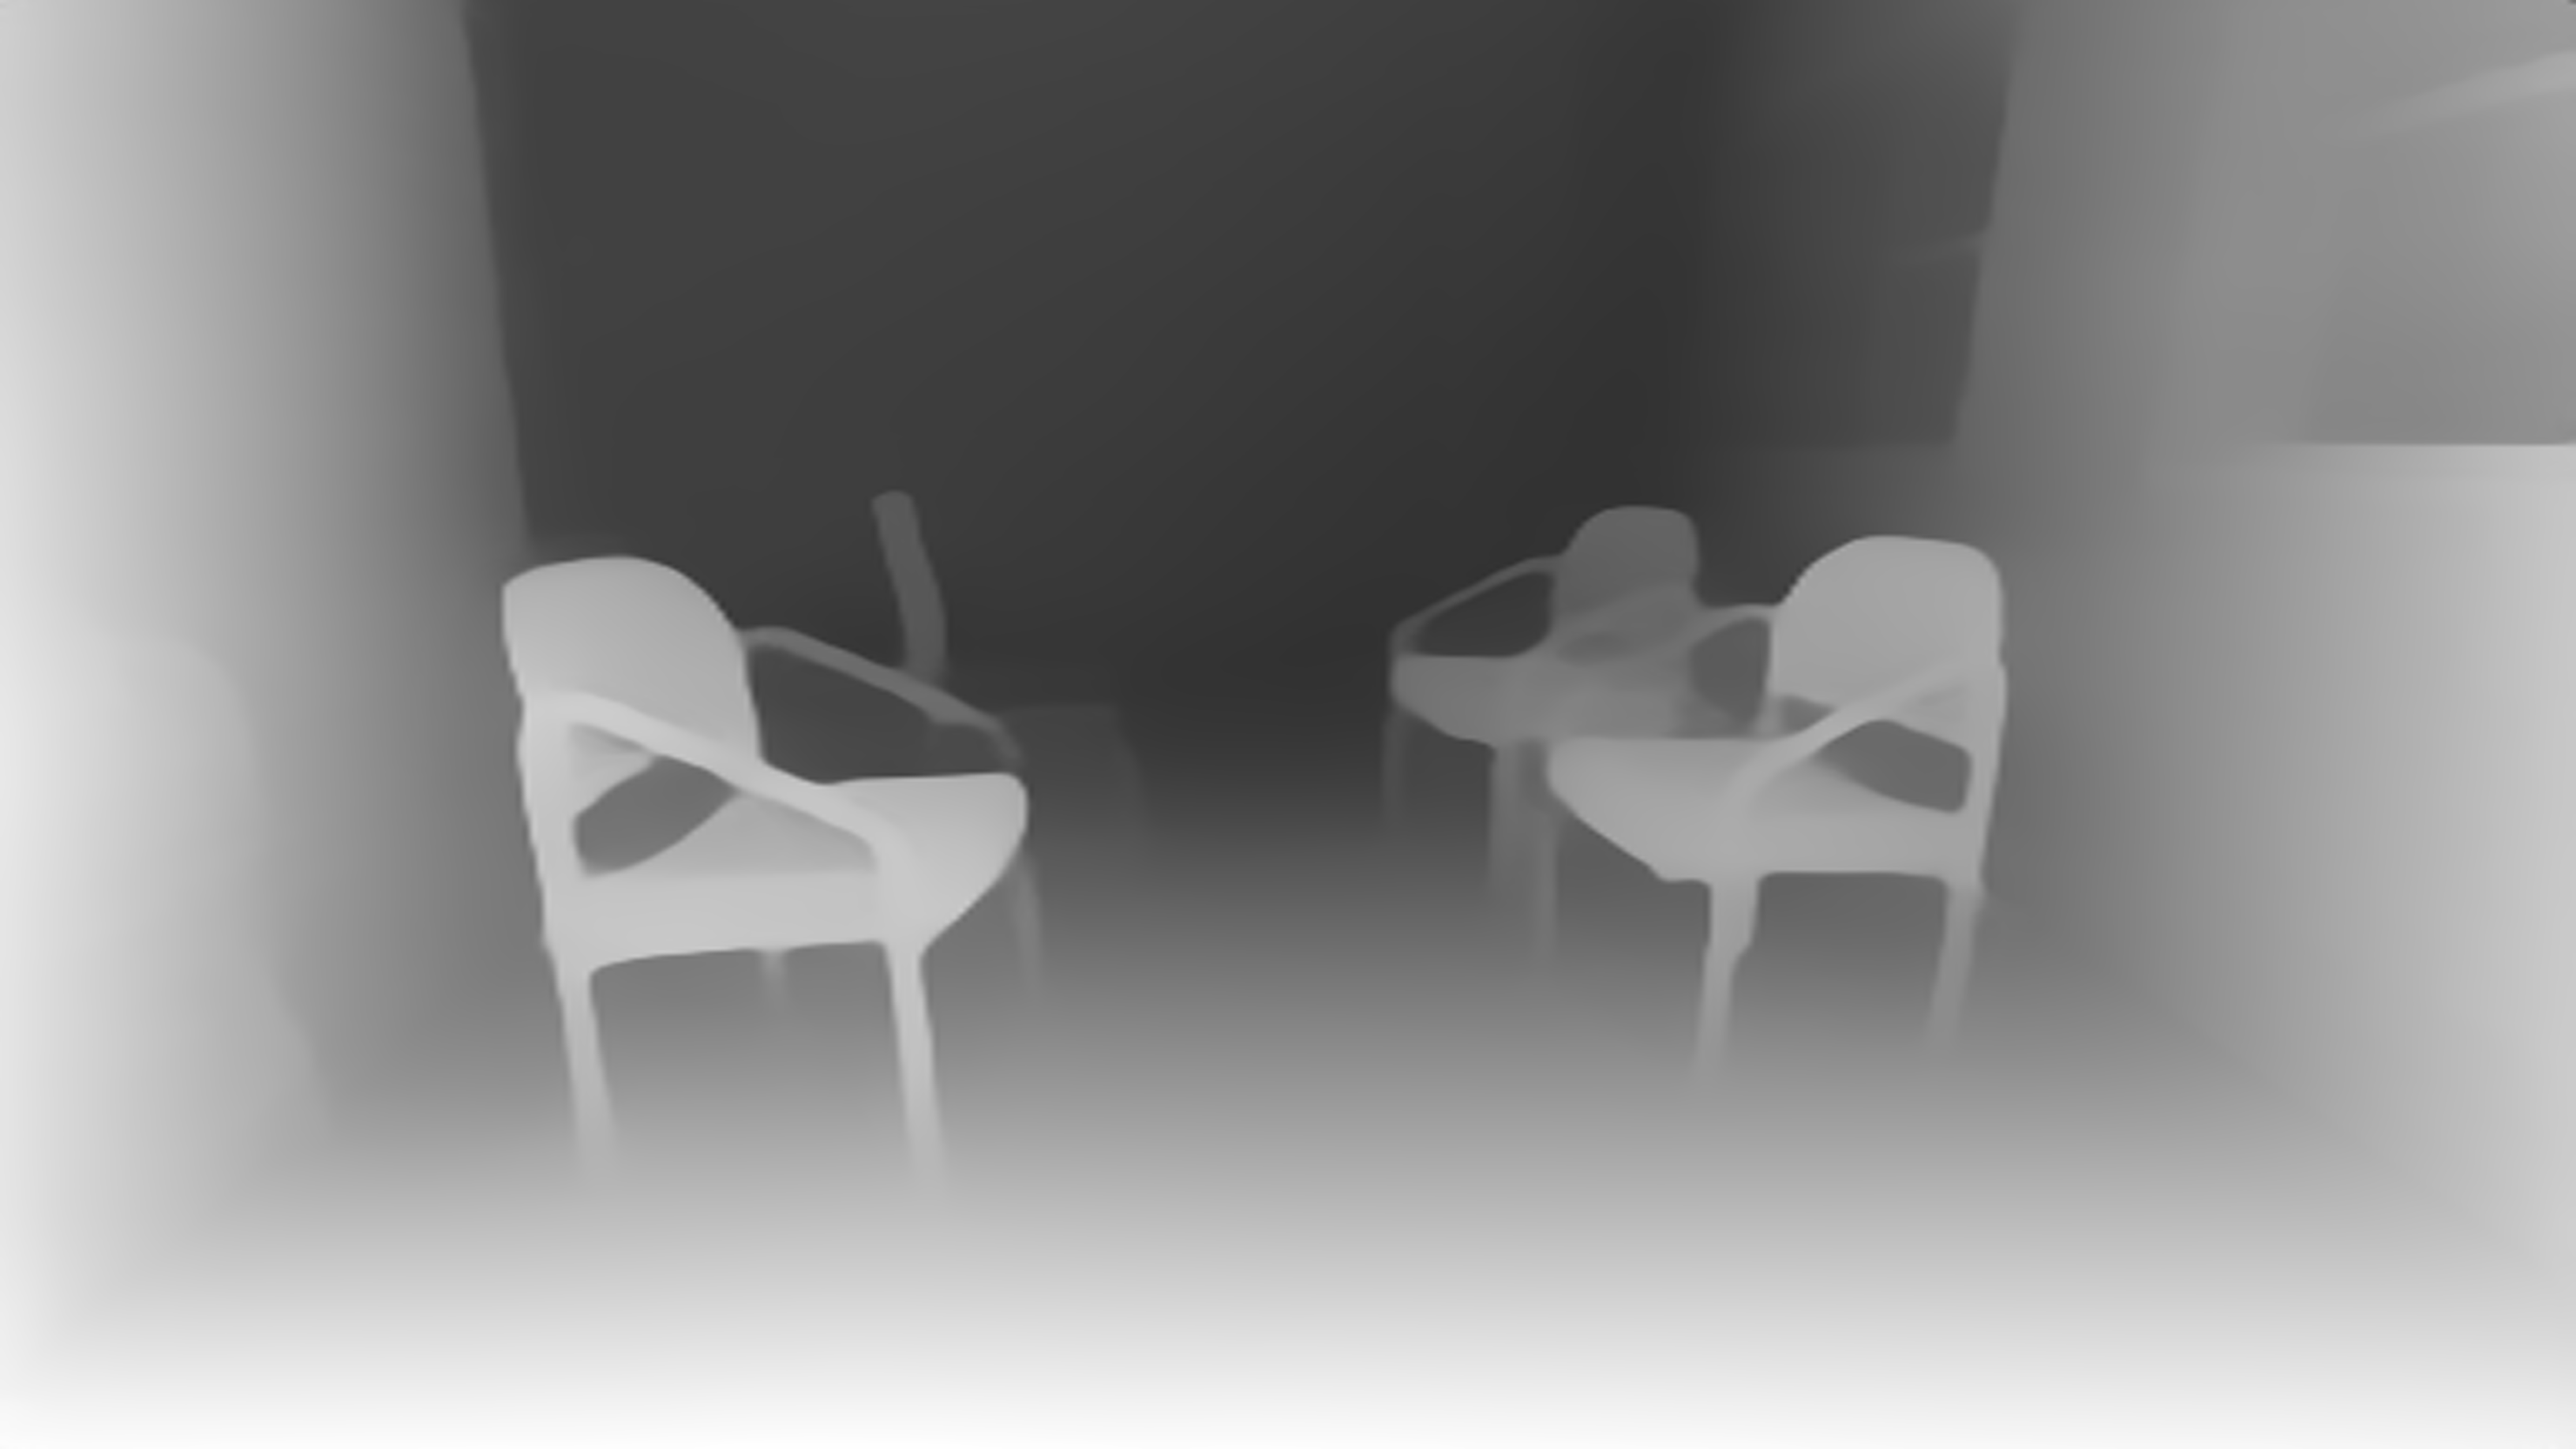

In [4]:
depth['depth']

In [5]:
tn = depth['predicted_depth']

In [6]:
tn.max()

tensor(1891.7715)

In [7]:
tn.min()

tensor(367.2822)

In [8]:
# Object detection:

from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image

image = Image.open(url)

# you can specify the revision tag if you don't want the timm dependency
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )


Detected chair with confidence 0.982 at location [992.27, 616.12, 1470.99, 1148.83]
Detected chair with confidence 0.999 at location [648.99, 701.09, 1348.2, 1544.17]
Detected chair with confidence 0.983 at location [1756.88, 634.6, 2160.24, 1168.27]
Detected chair with confidence 0.996 at location [1934.05, 666.75, 2550.89, 1413.34]


In [9]:
results

{'scores': tensor([0.9820, 0.9990, 0.9829, 0.9957], grad_fn=<IndexBackward0>),
 'labels': tensor([62, 62, 62, 62]),
 'boxes': tensor([[ 992.2732,  616.1166, 1470.9886, 1148.8347],
         [ 648.9907,  701.0887, 1348.1981, 1544.1655],
         [1756.8767,  634.6042, 2160.2417, 1168.2703],
         [1934.0546,  666.7515, 2550.8921, 1413.3380]],
        grad_fn=<IndexBackward0>)}

In [10]:
# Crop and get avg distance of object

import numpy as np

# Bounding boxes generated above in form (xmin, ymin, xmax, ymax)
boxes = []
for box in results["boxes"]:
    box = [round(i, 2) for i in box.tolist()]
    boxes.append(box)

objects = []
for i, bbox in enumerate(boxes):
    xmin, ymin, xmax, ymax = bbox[0], bbox[1], bbox[2], bbox[3]
    objects.append(depth['depth'].crop((xmin, ymin, xmax, ymax)))

objects

[<PIL.Image.Image image mode=L size=479x533>,
 <PIL.Image.Image image mode=L size=699x843>,
 <PIL.Image.Image image mode=L size=403x533>,
 <PIL.Image.Image image mode=L size=617x746>]

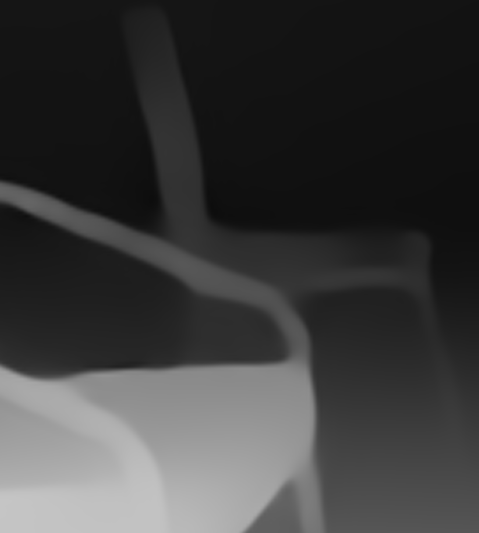

In [11]:
objects[0]

In [12]:
avgDist = []
for i, img in enumerate(objects):
    crop = np.array(img)
    print(crop)
    avgDist.append(np.mean(crop, axis=(0,1)))

avgDist

[[ 21  21  21 ...  19  19  19]
 [ 21  21  21 ...  18  18  18]
 [ 21  21  21 ...  18  18  18]
 ...
 [196 196 196 ...  85  85  85]
 [196 196 196 ...  85  85  85]
 [196 196 196 ...  85  85  85]]
[[ 95  95  95 ...  18  18  18]
 [ 95  95  95 ...  18  18  18]
 [ 95  95  95 ...  18  18  18]
 ...
 [183 183 183 ... 182 182 182]
 [183 183 183 ... 183 183 183]
 [183 183 183 ... 183 183 183]]
[[16 16 16 ... 20 20 20]
 [16 16 16 ... 20 20 20]
 [16 16 16 ... 20 20 20]
 ...
 [90 90 90 ... 91 91 92]
 [90 90 90 ... 91 92 92]
 [90 90 90 ... 92 92 92]]
[[ 16  16  16 ...  76  76  76]
 [ 16  16  16 ...  76  76  76]
 [ 16  16  16 ...  76  76  76]
 ...
 [150 150 150 ... 149 149 149]
 [151 151 151 ... 149 149 149]
 [151 151 151 ... 149 149 149]]


[60.00708167030281, 122.8918706099376, 66.43608676018044, 104.51369812419343]

In [13]:
def map_range(x, fromLow, fromHigh, toLow, toHigh):
    return (x - fromLow) * (toHigh - toLow) // (fromHigh - fromLow) + toLow

# Remap to 0-5m
ranges = []
for i, val in enumerate(avgDist):
    ranges.append(map_range(val, 0, 256, 0, 500))

ranges

[117.0, 240.0, 129.0, 204.0]

In [14]:
# Other variables:

cameraHeight = 165 #cm
roomDimensions = [300, 500] # w, l



In [15]:
# Convert to .json for LLM estimation
import json

exports = {}
for i, val in enumerate(ranges):
    tmp = "Object_" + str(i)
    exports[tmp] = {}  # Initialize as an empty dictionary
    newVal = val / 10
    exports[tmp]["location"] = "<Vector (0.0000, " + str(newVal) + ", 1.0000)>"
    exports[tmp]["size"] = "<Vector (1.0000, 1.0000, 1.0000)>"

exports


{'Object_0': {'location': '<Vector (0.0000, 11.7, 1.0000)>',
  'size': '<Vector (1.0000, 1.0000, 1.0000)>'},
 'Object_1': {'location': '<Vector (0.0000, 24.0, 1.0000)>',
  'size': '<Vector (1.0000, 1.0000, 1.0000)>'},
 'Object_2': {'location': '<Vector (0.0000, 12.9, 1.0000)>',
  'size': '<Vector (1.0000, 1.0000, 1.0000)>'},
 'Object_3': {'location': '<Vector (0.0000, 20.4, 1.0000)>',
  'size': '<Vector (1.0000, 1.0000, 1.0000)>'}}